# Fit halo mass to shear profile: 3. accounting for the redshift distribution of source galaxies

_the LSST-DESC CLMM team_


This notebook demonstrates how to use `clmm` to estimate a WL halo mass from observations of a galaxy cluster when source galaxies follow a given distribution (the Chang. (2013) implemented in `clmm`). It uses several functionalities of the support `mock_data` module to produce mock datasets.

- Setting things up, with the proper imports.
- Generating 2 datasets: an ideal datasetwith source galaxies following the Chang et al. (2013) redshift distribution; a noisy dataset where photoz errors and shape noise are also included. 
- Computing the binned reduced tangential shear profile, for the 2 datasets, using logarithmic binning.
- Setting up the "single source plane" model (model1) and a model accounting for the redshift distribution (model2). As already seen in Example2, model1 will yield a bias mass reconstruction. Accounting for the redshift distribution in the model (model2) solves that issue. 
- Perform a simple fit using `scipy.optimize.curve_fit` and visualize the results.

## Setup

First, we import some standard packages.

In [1]:
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
from astropy import units
plt.rcParams['font.family']=['gothambook','gotham','gotham-book','serif']

clmm.__version__

'0.9.0'

Next, we import `clmm`'s core modules.

In [2]:
import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology

We then import a support modules for a specific data sets.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.

## Making mock data

In [3]:
from clmm.support import mock_data as mock

For reproducibility:

In [4]:
np.random.seed(11)

To create mock data, we need to define a true cosmology, which is currently done with [`astropy`'s cosmology library](http://docs.astropy.org/en/stable/cosmology/index.html).

In [5]:
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

We now set some parameters for a mock galaxy cluster:

In [6]:
cluster_m = 1.e15 # M200,m [Msun]
logm = np.log(cluster_m)/np.log(10)
concentration = 4
cluster_ra = 0.
cluster_dec = 0.
cluster_z = 0.4
ngals = 10000

Then we use the `mock_data` support module to generate 2 galaxy catalogs:
- `ideal_data`: galaxies distributed according to the Chang et al. (2013) redshift distribution.
- `noisy_data`: `ideal_data` + photoz errors + shape noise

(Galaxies have a minimum redshift defined as $z_{cluster} + 0.1$)

In [7]:
ideal_data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 'chang13', zsrc_min = cluster_z + 0.1, ngals=ngals)
noisy_data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 'chang13', zsrc_min = cluster_z + 0.1,
                                          shapenoise=0.05, photoz_sigma_unscaled=0.05, ngals=ngals)

/Users/combet/anaconda3/envs/clmmenv/lib/python3.8/site-packages/numpy/ma/core.py:2831: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/combet/anaconda3/envs/clmmenv/lib/python3.8/site-packages/clmm-0.9.0-py3.8.egg/clmm/cosmology/cluster_toolkit.py:69: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/Users/combet/anaconda3/envs/clmmenv/lib/python3.8/site-packages/clmm-0.9.0-py3.8.egg/clmm/cosmology/cluster_toolkit.py:79: RuntimeWarning: divide by zero encountered in true_divide
/Users/combet/anaconda3/envs/clmmenv/lib/python3.8/site-packages/clmm-0.9.0-py3.8.egg/clmm/theory/func_layer.py:354: UserWarning: Some source redshifts are lower than the

The galaxy catalogs are converted to a `clmm.GalaxyCluster` object and may be saved for later use.

In [8]:
cluster_id = "CL_ideal"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                                  cluster_z, ideal_data)
gc_object.save('ideal_GC.pkl')

cluster_id = "CL_noisy"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                                   cluster_z, noisy_data)
gc_object.save('noisy_GC.pkl')

Any saved clmm.GalaxyCluster object may be read in for analysis.

In [9]:
cl_ideal = clmm.GalaxyCluster.load('ideal_GC.pkl') # background galaxies distributed according to Chang et al. (2013)
cl_noisy = clmm.GalaxyCluster.load('noisy_GC.pkl') # Chang et al. (2013) + shapenoise + photozerror

### Redshift of galaxies generated by mock data are distributed following the Chang. (2013) redshift distribution.

(0.0, 5.0)

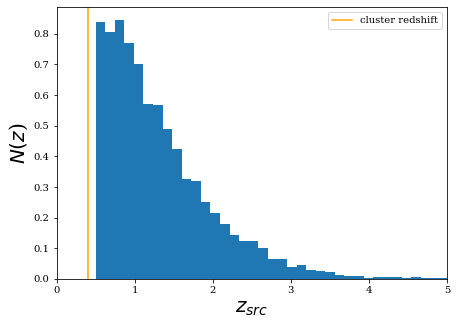

In [10]:
plt.figure(figsize=(7,5))
plt.hist(cl_ideal.galcat['z'], density = True, bins = 50)
plt.axvline(x = cluster_z, color='orange', label = 'cluster redshift')
plt.xlabel(r'$z_{src}$', fontsize = 20)
plt.ylabel(r'$N(z$)', fontsize = 20)
plt.legend()
plt.xlim(0,5)

## Deriving observables

### Computing shear

`clmm.GalaxyCluster.compute_tangential_and_cross_components` calculates the tangential and cross shears for each source galaxy in the cluster.

In [11]:
cl_ideal.compute_tangential_and_cross_components(geometry="flat")
cl_noisy.compute_tangential_and_cross_components(geometry="flat")
pass

### Radially binning the data

In [12]:
bin_edges = da.make_bins(0.2, 4, 15, method='evenlog10width')

`clmm.GalaxyCluster.make_radial_profile` evaluates the average shear of the galaxy catalog in bins of radius.

In [13]:
cl_ideal.make_radial_profile("Mpc", bins=bin_edges, cosmo=cosmo, gal_ids_in_bins=True)
cl_noisy.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo, gal_ids_in_bins=True)
pass

After this, the object acquires the `clmm.GalaxyCluster.profile` attribute.

## Create the reduced tangential shear models

We consider two options:
- First, the naive and *wrong* approach: the reduced tangential shear in a given radial bin $j$ is given by $g_t(\theta_j, \langle z_s \rangle)$, where $\langle z_s \rangle$ is the average redshift in the bin. In that case, the corresponding model is simply given by the fucntion below:

In [14]:
def model_reduced_tangential_shear_singlez(r, logm, z_src):
    m = 10.**logm
    gt_model = clmm.compute_reduced_tangential_shear(r,
                                                     m, concentration,
                                                     cluster_z, z_src, cosmo,
                                                     delta_mdef=200,
                                                     halo_profile_model='nfw')    
    return gt_model

- Second, the reduced tangential shear in a given radial bin accounts properly for the redshift distribution in the bin as $\langle g_t(\theta_j, z_s)\rangle \neq g_t(\theta_j, \langle z_s \rangle$). Formally, the reduced tangential shear that corresponds to a continuous distribution of source galaxy redshift $N(z)$ can be expressed as:

$$
g_t(\theta) = \langle g_t(\theta, z_s)\rangle_{z_{cluster}} = \int_{z_{cluster}}^{+\infty}dz_sN(z_s)g_t(\theta, z_s)
$$

If the inidividual redshifts of the background galaxies are known, we can directly build a model based on data, such that in the bin $j$: 

$$
g_t(\theta_j) = \frac{1}{N(\theta_j)}\sum\limits_{i = 1}^{N(\theta)}g_t(\theta_j, z_i)
$$

where $N(\theta_j)$ is the number of galaxies in bin $j$. The corresponding model is given below.

In [15]:
def model_reduced_tangential_shear_zdistrib(radius, logm, data, catalog, profile): 
    m = 10**logm
    gt_model = []
    for i in range(len(radius)):
        
        r = profile['radius'][i]
        galist = profile['gal_id'][i]
        z_list = catalog.galcat['z'][galist]
        shear = clmm.compute_reduced_tangential_shear(r, m, concentration, 
                                                      cluster_z, z_list, cosmo, delta_mdef=200, 
                                                      halo_profile_model='nfw')
        gt_model.append(np.mean(shear))
        
    return gt_model

### Before fitting, let's first vizualise these models using the known true mass

In [16]:
logm = np.log10(cluster_m)
r = cl_ideal.profile['radius']
gt_model_ideal_singlez = model_reduced_tangential_shear_singlez(r, logm, cl_ideal.profile['z'])
gt_model_ideal_zdistrib = model_reduced_tangential_shear_zdistrib(r,logm, ideal_data, cl_ideal, cl_ideal.profile)
gt_model_noisy_singlez = model_reduced_tangential_shear_singlez(r,logm, cl_noisy.profile['z'])
gt_model_noisy_zdistrib = model_reduced_tangential_shear_zdistrib(r,logm, noisy_data, cl_noisy, cl_noisy.profile)

/Users/combet/anaconda3/envs/clmmenv/lib/python3.8/site-packages/clmm-0.9.0-py3.8.egg/clmm/theory/func_layer.py:425: UserWarning: Some source redshifts are lower than the cluster redshift. shear = 0 for those galaxies.


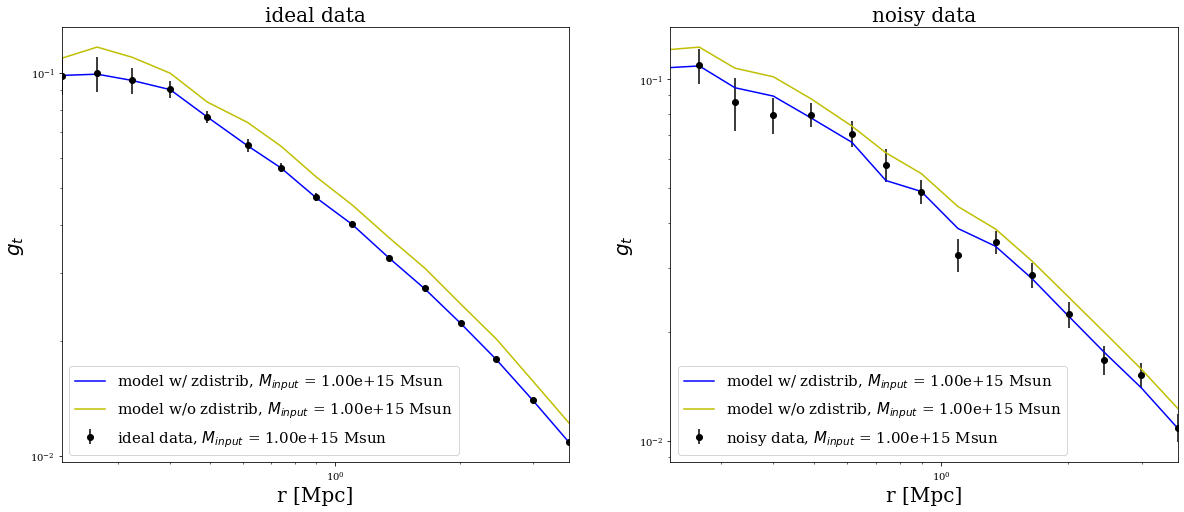

In [17]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)

plt.title('ideal data', fontsize=20)
plt.errorbar(r,cl_ideal.profile['gt'],cl_ideal.profile['gt_err'],c='k',linestyle='', 
             marker='o', label=r'ideal data, $M_{input}$ = %.2e Msun' % cluster_m)
plt.loglog(r,gt_model_ideal_zdistrib,'b',  label=r'model w/ zdistrib, $M_{input}$ = %.2e Msun' % cluster_m)
plt.loglog(r,gt_model_ideal_singlez,'-y',  label=r'model w/o zdistrib, $M_{input}$ = %.2e Msun' % cluster_m)
plt.xlabel('r [Mpc]', fontsize = 20)
plt.ylabel(r'$g_t$', fontsize = 20)
plt.xlim(min(cl_ideal.profile['radius']), max(cl_ideal.profile['radius']))
plt.legend(fontsize = 15)

plt.subplot(1,2,2)

plt.title('noisy data', fontsize=20)
plt.errorbar(r,cl_noisy.profile['gt'],cl_noisy.profile['gt_err'],c='k',linestyle='', 
             marker='o',label=r'noisy data, $M_{input}$ = %.2e Msun' % cluster_m)
plt.loglog(r,gt_model_noisy_zdistrib,'-b', label=r'model w/ zdistrib, $M_{input}$ = %.2e Msun' % cluster_m)
plt.loglog(r,gt_model_noisy_singlez,'-y', label=r'model w/o zdistrib, $M_{input}$ = %.2e Msun' % cluster_m)
plt.xlabel('r [Mpc]', fontsize = 20)
plt.ylabel(r'$g_t$', fontsize = 20)
plt.xlim(min(cl_noisy.profile['radius']), max(cl_noisy.profile['radius']))
plt.legend(fontsize = 15)

The naive model that uses the average redshift in the bin clearly does not give the right description of the ideal data (left panel), and will yield biased mass results if used for fitting (see below). For ideal data, the model that accounts for the redshift distribution is, by construction, an excellent description of the data (solid blue line). The same is true for noisy data (right panel), although the noise make the naive model appear "less biased".

## Mass fitting

We estimate the best-fit mass using `scipy.optimize.curve_fit`.  We compare estimated mass for noisy and ideal data, using both models described above (naive with average redshift or the model taking into account the redshift distribution). The choice of fitting $\log_{10} M$ instead of $M$ lowers the range of pre-defined fitting bounds from several order of magnitude for the mass to unity. From the associated error $\Delta (\log_{10}M)$ we calculate the error to mass as $\Delta M = M_{fit}\log(10)\Delta (\log_{10}M)$.

In [18]:
from clmm.support.sampler import fitters

In [19]:
popt,pcov = fitters['curve_fit'](lambda r, logm:model_reduced_tangential_shear_zdistrib(r, logm, ideal_data, cl_ideal, cl_ideal.profile), 
                        cl_ideal.profile['radius'], 
                        cl_ideal.profile['gt'], 
                        cl_ideal.profile['gt_err'], bounds=[10.,16.])

m_est_ideal_zdistrib = 10.**popt[0]
m_est_err_ideal_zdistrib =  m_est_ideal_zdistrib * np.sqrt(pcov[0][0]) * np.log(10) 

popt,pcov = fitters['curve_fit'](lambda r, logm:model_reduced_tangential_shear_singlez(r, logm, cl_ideal.profile['z']), 
                        cl_ideal.profile['radius'], 
                        cl_ideal.profile['gt'], 
                        cl_ideal.profile['gt_err'], bounds=[10.,17.])

m_est_ideal_singlez = 10.**popt[0]
m_est_err_ideal_singlez =  m_est_ideal_singlez * np.sqrt(pcov[0][0]) * np.log(10) 


popt,pcov = fitters['curve_fit'](lambda r, logm:model_reduced_tangential_shear_zdistrib(r, logm, noisy_data, cl_noisy, cl_noisy.profile), 
                        cl_noisy.profile['radius'], 
                        cl_noisy.profile['gt'], 
                        cl_noisy.profile['gt_err'], bounds=[10.,16.])

m_est_noisy_zdistrib = 10.**popt[0]
m_est_err_noisy_zdistrib =  m_est_noisy_zdistrib * np.sqrt(pcov[0][0]) * np.log(10) 

popt,pcov = fitters['curve_fit'](lambda r, logm:model_reduced_tangential_shear_singlez(r, logm, cl_noisy.profile['z']), 
                        cl_noisy.profile['radius'], 
                        cl_noisy.profile['gt'], 
                        cl_noisy.profile['gt_err'], bounds=[10.,16.])

m_est_noisy_singlez = 10.**popt[0]
m_est_err_noisy_singlez =  m_est_noisy_singlez * np.sqrt(pcov[0][0]) * np.log(10) 


/Users/combet/anaconda3/envs/clmmenv/lib/python3.8/site-packages/clmm-0.9.0-py3.8.egg/clmm/cosmology/cluster_toolkit.py:69: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/Users/combet/anaconda3/envs/clmmenv/lib/python3.8/site-packages/clmm-0.9.0-py3.8.egg/clmm/cosmology/cluster_toolkit.py:79: RuntimeWarning: divide by zero encountered in true_divide
/Users/combet/anaconda3/envs/clmmenv/lib/python3.8/site-packages/clmm-0.9.0-py3.8.egg/clmm/theory/func_layer.py:425: UserWarning: Some source redshifts are lower than the cluster redshift. shear = 0 for those galaxies.


In [20]:
print(f'The input mass = {cluster_m:.2e} Msun\n')

print("Without accounting for the redshift distribution in the model\n")
print(f'Best fit mass for ideal data = {m_est_ideal_singlez:.2e} +/- {m_est_err_ideal_singlez:.2e} Msun')
print(f'Best fit mass for noisy data = {m_est_noisy_singlez:.2e} +/- {m_est_err_noisy_singlez:.2e} Msun\n')

print("Accounting for the redshift distribution in the model\n")
print(f'Best fit mass for ideal data = {m_est_ideal_zdistrib:.2e} +/- {m_est_err_ideal_zdistrib:.2e} Msun')
print(f'Best fit mass for noisy data = {m_est_noisy_zdistrib:.2e} +/- {m_est_err_noisy_zdistrib:.2e} Msun')

The input mass = 1.00e+15 Msun

Without accounting for the redshift distribution in the model

Best fit mass for ideal data = 8.56e+14 +/- 3.21e+12 Msun
Best fit mass for noisy data = 8.32e+14 +/- 2.31e+13 Msun

Accounting for the redshift distribution in the model

Best fit mass for ideal data = 1.01e+15 +/- 2.16e+11 Msun
Best fit mass for noisy data = 1.00e+15 +/- 2.66e+13 Msun


As expected, the reconstructed mass is biased when the redshift distribution is not accounted for in the model

## Visualization of the results

For visualization purpose, we calculate the reduced tangential shear predicted by the model with estimated masses for noisy and ideal data.

In [21]:
gt_est_ideal_zdistrib = model_reduced_tangential_shear_zdistrib(r,np.log(m_est_ideal_zdistrib)/np.log(10), ideal_data, cl_ideal, cl_ideal.profile)
gt_est_noisy_zdistrib = model_reduced_tangential_shear_zdistrib(r,np.log(m_est_noisy_zdistrib)/np.log(10), noisy_data, cl_noisy, cl_noisy.profile)
gt_est_ideal_singlez = model_reduced_tangential_shear_singlez(r,np.log(m_est_ideal_singlez)/np.log(10),  cl_ideal.profile['z'])
gt_est_noisy_singlez = model_reduced_tangential_shear_singlez(r,np.log(m_est_noisy_singlez)/np.log(10),  cl_noisy.profile['z'])

We compare to tangential shear obtained with theoretical mass. We plot the reduced tangential shear models first when redshift distribution is accounted for in the model then for the naive approach, with respective best-fit masses.

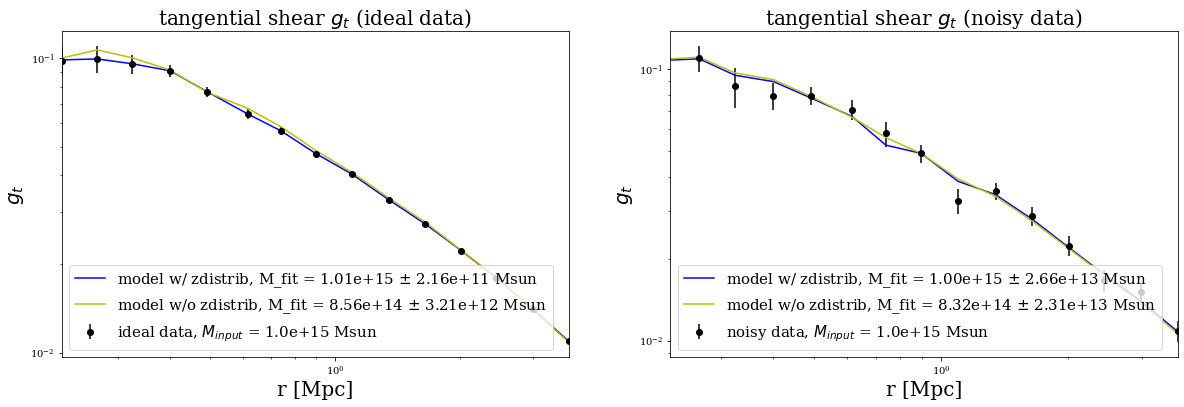

In [22]:
plt.figure(figsize=( 20 , 6 ))
plt.subplot( 1 , 2 , 1 )
plt.title(r'tangential shear $g_t$ (ideal data)', fontsize=20)
plt.errorbar(r,cl_ideal.profile['gt'],cl_ideal.profile['gt_err'],c='k',linestyle='', 
             marker='o', label=r'ideal data, $M_{input}$ = %.1e Msun' % cluster_m)
plt.loglog(r,gt_est_ideal_zdistrib,'-b', 
           label=fr'model w/ zdistrib, M_fit = {m_est_ideal_zdistrib:.2e} $\pm$ {m_est_err_ideal_zdistrib:.2e} Msun')
plt.loglog(r,gt_est_ideal_singlez,'-y',\
           label=fr'model w/o zdistrib, M_fit = {m_est_ideal_singlez:.2e} $\pm$ {m_est_err_ideal_singlez:.2e} Msun')

plt.xlabel('r [Mpc]', fontsize = 20)
plt.ylabel(r'$g_t$', fontsize = 20)
plt.xlim(min(cl_ideal.profile['radius']), max(cl_ideal.profile['radius']))
plt.legend(fontsize = 15)


plt.subplot( 1 , 2 , 2 )
plt.title(r'tangential shear $g_t$ (noisy data)', fontsize=20)
plt.errorbar(r,cl_noisy.profile['gt'],cl_noisy.profile['gt_err'],c='k',linestyle='', marker='o', label=r'noisy data, $M_{input}$ = %.1e Msun' % cluster_m)
#plt.loglog(r,gt_model_noisy,'-r',  label='model, $M_{input}$ = %.3e Msun' % cluster_m)
plt.loglog(r,gt_est_noisy_zdistrib,'-b', 
           label=fr'model w/ zdistrib, M_fit = {m_est_noisy_zdistrib:.2e} $\pm$ {m_est_err_noisy_zdistrib:.2e} Msun')
plt.loglog(r,gt_est_noisy_singlez,'-y', 
           label=fr'model w/o zdistrib, M_fit = {m_est_noisy_singlez:.2e} $\pm$ {m_est_err_noisy_singlez:.2e} Msun')

plt.xlabel('r [Mpc]', fontsize = 20)
plt.ylabel(r'$g_t$', fontsize = 20)
plt.xlim(min(cl_noisy.profile['radius']), max(cl_noisy.profile['radius']))
plt.legend(fontsize = 15)

We note that the reconstruction of mass is biaised when redshift distribution is not accounted for the model, and is smaller compared to input mass. It is associated to the increase of the reduced tangential shear with the source redshift $z_s$ for a given radius $r$. 